In [1]:
from ultralytics import YOLO
import os
import yaml
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
data_dir = '/home/pepsi/dev_ws/mldl/Training/datasets/Fire'
model = "yolo11n.pt"
classes = ['fire']
nc = len(classes)
yaml_file = 'data.yaml'

In [3]:
data = {
    'train': data_dir + '/train/',
    'val': data_dir + '/valid/',
    'test': data_dir + '/test/',
    'nc': nc,
    'names': classes
}

In [4]:
os.makedirs(data_dir, exist_ok=True)

with open(data_dir + '/' + 'data.yaml', 'wt') as fw:
    yaml.dump(data, fw)

In [5]:
with open(data_dir + '/' + 'data.yaml', 'rt') as ft:
    data = yaml.safe_load(ft)
    print(data)


{'names': ['fire'], 'nc': 1, 'test': '/home/pepsi/dev_ws/mldl/Training/datasets/Fire/test/', 'train': '/home/pepsi/dev_ws/mldl/Training/datasets/Fire/train/', 'val': '/home/pepsi/dev_ws/mldl/Training/datasets/Fire/valid/'}


In [6]:
EPOCHS = 200
BATCH_SIZE = 32
PATIENCE = 30
OPTIMIZER = "Adamw"
LR = 0.0001

In [ ]:
YOLO_model = YOLO(model).to(device)

YOLO_model.train(data=data_dir + '/' + yaml_file,
                 epochs=EPOCHS,
                 patience=PATIENCE,
                 batch=BATCH_SIZE,
                 lr0 = LR,
                 optimizer=OPTIMIZER)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

best_model = YOLO('/home/pepsi/dev_ws/deeplearning-repo-2/src/video_ai_server/runs/detect/train/weights/fire_detect_model.pt').to(device)
metrics = best_model.val()

log_path = "/home/pepsi/dev_ws/deeplearning-repo-2/src/video_ai_server/runs/detect/train/results.csv"

df = pd.read_csv(log_path)
df.head()

YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /home/pepsi/dev_ws/mldl/Training/datasets/Fire/valid/labels.cache... 601 images, 5 backgrounds, 0 corrupt: 100%|██████████| 601/601 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  7.04it/s]


                   all        601       1020      0.951      0.918      0.959      0.674
Speed: 1.0ms preprocess, 3.8ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val


,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,62.4572,1.83313,2.12079,1.64978,0.59662,0.18725,0.26217,0.09671,2.17149,3.05133,1.97071,0.066920,0.000033,0.000033
1,2,116.5010,1.69215,1.51265,1.53626,0.69900,0.62647,0.68133,0.34520,1.61930,1.31085,1.48661,0.033620,0.000066,0.000066
2,3,171.5410,1.59870,1.31516,1.45564,0.82584,0.69706,0.80009,0.40977,1.58467,1.16287,1.41250,0.000320,0.000099,0.000099
3,4,227.3530,1.56105,1.24652,1.42750,0.81580,0.70098,0.80411,0.42032,1.54918,1.15301,1.38024,0.000099,0.000099,0.000099
4,5,280.2990,1.54873,1.19297,1.42128,0.83660,0.69510,0.80105,0.45498,1.47331,1.04363,1.35271,0.000098,0.000098,0.000098


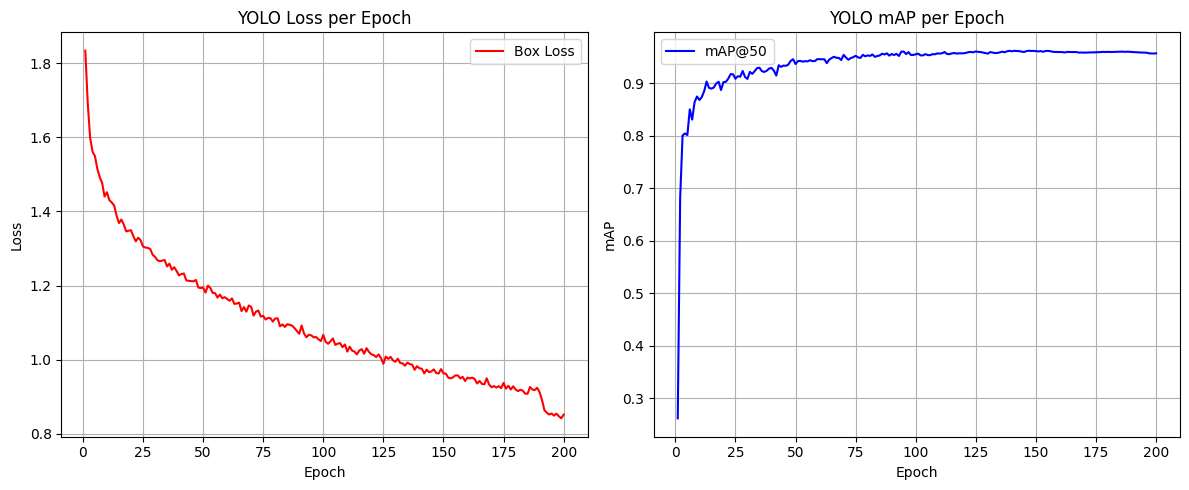

In [5]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train/box_loss'], label='Box Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('YOLO Loss per Epoch')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@50', color='blue')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('YOLO mAP per Epoch')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [7]:
import cv2
import numpy as np

cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()

    if ret:
        blur_frame = cv2.GaussianBlur(frame, (5, 5), 0)

        # 모델 예측
        results = best_model(blur_frame)

        if len(results) > 0:  # 리스트가 비어있는지 확인
            result = results[0]  # 첫 번째 결과 가져오기
            
            if hasattr(result, "boxes") and result.boxes is not None:
                boxes = result.boxes.xyxy.cpu().numpy()  # 바운딩 박스 좌표
                confs = result.boxes.conf.cpu().numpy()  # 신뢰도
                cls_ids = result.boxes.cls.cpu().numpy()  # 클래스 ID
                
                for box, conf, cls_id in zip(boxes, confs, cls_ids):
                    if conf > 0.5:  # 신뢰도 50% 이상만 표시
                        x1, y1, x2, y2 = map(int, box)  # 바운딩 박스 좌표
                        label = f"{result.names[int(cls_id)]} {conf:.2f}"  # 라벨 및 신뢰도

                        # 바운딩 박스 그리기
                        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

                        # 라벨 텍스트 추가
                        cv2.putText(frame, label, (x1, y1 - 10),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        cv2.imshow("test_frame", frame)

        if cv2.waitKey(1) == ord('q'):
            break
    else:
        break

cap.release()
cv2.destroyAllWindows()



0: 480x640 (no detections), 40.5ms
Speed: 1.8ms preprocess, 40.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 9.0ms
Speed: 1.6ms preprocess, 9.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 17.1ms
Speed: 2.6ms preprocess, 17.1ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 13.8ms
Speed: 2.9ms preprocess, 13.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 17.8ms
Speed: 4.5ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 14.5ms
Speed: 4.6ms preprocess, 14.5ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 12.4ms
Speed: 5.0ms preprocess, 12.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 12.9ms
Speed: 3.7ms preprocess, 12.9ms inf